In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa

In [2]:
from dask import dataframe as dd 
from dask import array as da
from dask.diagnostics import ProgressBar # type: ignore

In [30]:
# read h5
embeddings = dd.read_hdf('embeddings.h5', key='embeddings', mode='r', chunksize=1000)

# load 10'000
# embeddings = embeddings.head(10000)

In [18]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.242721,0.416596,-0.247983,-0.269344,-0.045771,0.003983,-0.643093,0.709781,0.536804,-0.393591,-0.226286,-0.004065,0.427676,-0.769701,0.317048,0.034019,-0.574562,1.024235,0.070085,0.686391,-0.030442,-0.628442,-0.268902,0.185108,-0.193817,-0.229135,-0.586822,-0.062442,-0.091804,0.076767,-0.273745,-0.619352,-0.119497,0.574538,0.142518,-0.671790,-0.430087,-0.108814,0.561862,0.724597,...,-1.083683,-0.293459,0.451924,0.531324,1.023726,-0.422590,-0.190925,0.586991,-0.207427,-0.000843,0.049753,0.853025,-0.810632,0.220397,-0.028880,-0.126696,-0.314804,0.038096,0.116631,0.301718,-0.293855,0.183650,0.567192,-0.085763,-0.693598,-0.167441,0.655166,0.092498,0.084725,0.264523,-0.278954,-0.444132,0.322713,-0.328574,-0.341612,0.522995,-0.866399,0.181326,0.082756,0.199519
1,0.050176,0.300104,0.043600,0.085409,0.293300,0.054499,-0.394082,0.624031,0.046269,-0.905075,0.297111,0.237447,0.278604,-0.436660,0.352575,0.160846,-0.550752,1.072164,0.172433,0.430814,-0.238517,-0.690049,-0.274390,0.027162,-0.243143,0.076985,-0.406872,-0.338619,-0.183564,-0.024003,-0.497969,-0.865221,-0.209452,0.307209,0.150011,-1.065233,-0.548951,-0.269440,0.500038,0.398316,...,-0.557699,-0.027481,0.235611,0.154877,0.916829,-0.380869,-0.193471,0.481143,-0.143135,-0.283558,0.200568,0.293281,-1.091376,0.190962,-0.509566,-0.045706,-0.432775,0.085886,0.555797,0.573433,-0.313099,0.035955,0.365593,-0.163994,-0.945225,-0.387506,0.809473,-0.246819,0.289053,0.480900,-0.129070,-0.091093,0.291247,-0.680475,-0.360574,0.428429,-0.698832,0.035107,0.150640,0.537492
2,-0.073493,-0.554840,-0.154205,1.224608,-0.021853,0.167990,-0.546410,0.434660,0.372562,0.506185,0.286930,0.127020,0.697138,-0.352146,-0.103998,-0.191454,0.665254,0.249263,0.213609,0.201675,-0.195812,-0.679235,-0.366973,0.172982,-0.409999,0.297531,-0.057041,-0.096151,1.242711,-0.187962,-0.528245,-0.732590,-0.256617,0.117410,0.388592,-1.039764,-0.712502,-0.370670,0.222278,0.518613,...,-0.061299,0.175254,-0.187856,0.312275,0.798309,-0.285825,-0.300410,-0.254376,-0.639686,-0.512621,0.472851,0.847658,0.272852,-0.378074,-0.210420,-0.811870,-0.428583,0.344318,-0.279271,0.600277,0.369242,-0.404921,0.593281,0.432525,-0.594313,0.222794,0.619339,-0.065067,0.905884,-0.133158,0.341457,0.355590,0.062959,0.187084,0.297098,0.605960,-0.244980,0.410118,0.038704,0.505363
3,-0.376492,0.100939,0.185906,-0.195942,-0.133067,-0.308304,-0.164811,-0.006943,-0.158194,-0.275358,0.900536,0.180947,-0.180618,-0.038291,0.014181,-0.060437,0.888856,0.046946,0.674771,0.440678,0.057911,-0.221371,-0.007153,-0.206570,-0.221413,-0.189212,-0.573802,-0.144431,0.305639,-0.033167,-0.187799,-1.451682,-0.316769,0.372095,-0.796807,-0.373156,0.245397,-0.858544,0.339569,0.153016,...,-0.303786,-0.382448,-0.083943,0.128670,0.295178,0.782921,0.234789,0.433882,-0.096848,-0.062156,0.197056,0.563411,-0.107292,0.549693,0.707901,-0.328103,0.343970,0.417285,0.651753,0.480133,-0.691943,0.193179,0.728872,-0.100067,-0.489544,-0.153068,0.577123,-0.653500,0.061357,0.752144,-0.267996,-0.301235,0.391637,0.086361,0.163313,0.592806,0.013871,0.141489,0.321801,-0.102912
4,-0.497712,0.457880,0.340294,0.525480,-0.370195,-0.243208,0.085796,0.192543,-0.146180,-0.187930,-0.005790,0.241527,-0.460870,0.086976,0.023700,-0.082243,0.874379,0.556892,0.670728,0.103735,-0.489152,-0.055759,-0.029752,0.394642,-0.199964,-0.301507,-0.423050,-0.039197,1.056769,-0.355023,-0.589944,-0.789548,-0.335117,0.494584,-0.750818,-1.014171,-0.257049,0.095245,0.613126,0.165573,...,0.045217,-0.250929,0.030475,0.425073,-0.223174,0.113632,0.068315,-0.547261,0.482851,0.469414,0.545766,0.124590,-0.596703,0.269373,0.473654,0.181156,-0.787097,0.289454,0.367839,0.820717,-0.598049,0.468182,0.178540,-0.066663,-0.414407,0.042812,-0.086610,-0.310789,0.577574,0.19

In [32]:
embeddings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
npartitions=552,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,floa

In [33]:
embeddings.shape

(<dask_expr.expr.Scalar: expr=FromGraph(628d73e).size() // 768, dtype=int64>,
 768)

In [21]:
from torch import nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torch
device = torch.device("cuda")

In [22]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1  = nn.Linear(768, 512)
        self.linear11 = nn.Linear(512, 512)
        self.linear2  = nn.Linear(512, latent_dims)
        self.linear3  = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear11(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear11 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, 768)

    def forward(self, z):
        z = F.elu(self.linear1(z))
        z = F.elu(self.linear11(z))
        z = F.elu(self.linear2(z))
        return z

In [23]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [24]:
# from torch.utils.data import DataLoader, TensorDataset

# # Convert Dask DataFrame to NumPy array
# embeddings_np = embeddings.compute().values

# # Convert NumPy array to PyTorch tensor
# embeddings_tensor = torch.tensor(embeddings_np, dtype=torch.float32, device=device)

# # Create a TensorDataset
# dataset = TensorDataset(embeddings_tensor)

In [25]:
# embeddings_np.max()

In [26]:
# import tqdm

# x_dim = int(embeddings.shape[1])
# latent_dim = 2
# hidden_dim = 50

# model = VariationalAutoencoder(latent_dim).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

# batch_size = 10_000

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# total_batches = len(dataloader)

# model.train()

# for epoch in range(30):
#     overall_loss = 0
#     overall_reconstruction_loss = 0

#     batches = tqdm.tqdm(enumerate(dataloader), total=total_batches)
#     batches.set_description(f"Epoch {epoch + 1}")
#     for batch_idx, (x,) in batches:
#         x = x.to(device)
#         optimizer.zero_grad()

#         x_hat = model(x)
#         loss =  ((x - x_hat)**2).sum() + model.encoder.kl 
        
#         overall_loss += loss.item() / len(x)
#         overall_reconstruction_loss += ((x - x_hat)**2).sum().item() / len(x)
        
#         loss.backward()
#         optimizer.step()

#         batches.set_postfix(loss=overall_loss / (batch_idx + 1))

#     if epoch == 3:
#         optimizer.param_groups[0]['lr'] = 1e-3

#     if epoch == 10:
#         optimizer.param_groups[0]['lr'] = 1e-4

#     if epoch == 20:
#         optimizer.param_groups[0]['lr'] = 1e-6
        
#     print("Epoch", epoch + 1, "Average Loss: ", overall_loss / (batch_size), "Reconstruction Loss: ", overall_reconstruction_loss / (batch_size))

In [27]:
# # Transform all embeddings into the latent space
# with torch.no_grad():
#     embeddings_latent = model.encoder(embeddings_tensor)

# # Convert to numpy array if needed
# embeddings_latent_np = embeddings_latent.cpu().numpy()

# # Print the shape of the new latent embeddings
# print(embeddings_latent_np.shape)

In [34]:
embeddings_size = embeddings.to_dask_array(lengths=True)

In [38]:
# explain memory usage by dask
embeddings_size

dask.array<values, shape=(551657, 768), dtype=float32, chunksize=(1000, 768), chunktype=numpy.ndarray>

In [37]:
from dask_ml.decomposition import PCA

pca = PCA(n_components=100)

embeddings_pca = pca.fit_transform(embeddings_size)

embeddings_pca

dask.array<mul, shape=(551657, 100), dtype=float32, chunksize=(1000, 100), chunktype=numpy.ndarray>

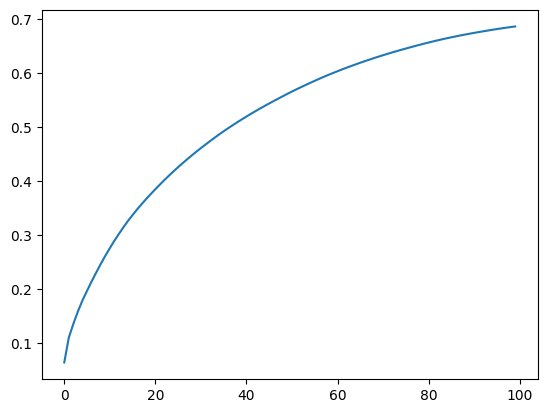

In [40]:
# explain variance
import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [42]:
embeddings_pca

dask.array<mul, shape=(551657, 100), dtype=float32, chunksize=(1000, 100), chunktype=numpy.ndarray>

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=150,
    init='random',
    n_init=5,
    verbose=1,
)

kmeans.fit(embeddings_pca)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def cluster_and_mesure(n_clusters, data):
    kmeans = KMeans(
        n_clusters=150,
        init='random',
    )
    kmeans.fit(data)

    # take random subset of data (100k)
    idxs = np.random.choice(data.shape[0], 100_000, replace=False)

    score = silhouette_score(data[idxs], kmeans.labels_[idxs])

    return score


cluster_and_mesure(150, embeddings_pca)

c:\Users\Maciej\miniconda3\envs\pytorch\lib\site-packages\dask\array\core.py:1709: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [48]:
# save embedded space
latent_space_df = pd.DataFrame(embeddings_latent_np)
latent_space_df.to_hdf('latent_space.h5', key='latent_space', mode='w')

In [49]:
cluster_labels = kmeans.labels_
cluster_labels

array([ 53,  53, 118, ...,  70,  53,  24], dtype=int32)

In [50]:
# debug clustering results
kmeans.cluster_centers_.shape

(150, 2)

In [51]:
kmeans.cluster_centers_[0]

array([-1.2977479, -1.027418 ], dtype=float32)

In [52]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.decomposition import IncrementalPCA

# isomap = Isomap(n_components=2, n_neighbors=15, p=2)
# lle = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
pca = IncrementalPCA(n_components=2)

transformed_embeddings = pca.fit_transform(embeddings_latent_np)

In [53]:
transformed_embeddings.shape

(551657, 2)

In [54]:
# error of the embedding
pca.explained_variance_ratio_

array([0.54784457, 0.45215543])

In [55]:
embeddings_latent_np.shape

(551657, 2)

In [56]:
transformed_embeddings.shape

(551657, 2)

In [57]:
embeddings_latent_np[:10]

array([[-0.8570561 ,  0.39298123],
       [-0.9412669 ,  0.38953438],
       [-0.9458833 ,  0.18851502],
       [-0.7798315 , -0.04957933],
       [-0.83251005,  0.37905842],
       [-0.63226056,  0.46107277],
       [-0.83098745,  0.4566638 ],
       [-0.6298559 ,  0.2940662 ],
       [-0.8801602 ,  0.19601914],
       [-1.1815792 ,  0.14554295]], dtype=float32)

In [58]:
# save
transformed_embeddings = pd.DataFrame(embeddings_latent_np)
transformed_embeddings.to_hdf('tsne_embeddings_3.h5', key='tsne_embeddings', mode='w', format='table')

In [59]:
transformed_embeddings

,0,1
0,-0.857056,0.392981
1,-0.941267,0.389534
2,-0.945883,0.188515
3,-0.779832,-0.049579
4,-0.832510,0.379058
...,...,...
551652,-0.779755,-0.966252
551653,-0.923247,0.600915
551654,-0.826822,0.320256
551655,-0.954018,0.547257


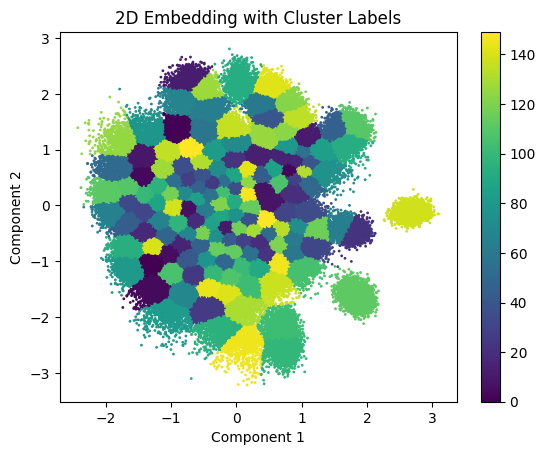

In [60]:
# plot
import matplotlib.pyplot as plt


plt.scatter(transformed_embeddings[0], transformed_embeddings[1], c=cluster_labels, cmap='viridis', s=1)
plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D Embedding with Cluster Labels')
plt.show()

In [63]:
# save to h5
tsne_embeddings = pd.DataFrame(transformed_embeddings)
tsne_embeddings.to_hdf('tsne_embeddings_2.h5', key='tsne_embeddings', mode='w', format='table')

In [64]:
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels.to_hdf('clusters_2.h5', key='clusters', mode='w', format='table')